# EDA
This notebook is used to perform exploratory data analysis on the data.


In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

path = %pwd
while "src" in path:
    %cd ..
    path = %pwd

import glob
import pandas as pd
import os
from tqdm.notebook import tqdm
from pprint import pprint

import matplotlib.pyplot as plt

from src.utils.parse_data import parse_ast, parse_concept, parse_relation

/mnt/c/Users/Mustapha/Documents/CENTRALESUPELEC_3A/challenge_IA/medical_txt_parser/src/notebooks
/mnt/c/Users/Mustapha/Documents/CENTRALESUPELEC_3A/challenge_IA/medical_txt_parser/src
/mnt/c/Users/Mustapha/Documents/CENTRALESUPELEC_3A/challenge_IA/medical_txt_parser


In [2]:
train_data_path = "data/train"
val_data_path = "data/val"
ast_folder_name = "ast"
concept_folder_name = "concept"
rel_folder_name = "rel"
txt_folder_name = "txt"

### Import data

In [3]:
text_files = glob.glob(train_data_path + os.sep + txt_folder_name + os.sep +  "*.txt")
filename = ""
df = pd.DataFrame()
for file in tqdm(text_files):
    with open(file, 'r') as f:
        text = f.read()
        filename = file.split("/")[-1].split(".")[0]
        ast = parse_ast(train_data_path + os.sep + ast_folder_name + os.sep +  filename + ".ast")
        concept = parse_concept(train_data_path + os.sep + concept_folder_name + os.sep +  filename + ".con")
        rel = parse_relation(train_data_path + os.sep + rel_folder_name + os.sep +  filename + ".rel")
        
        df = df.append(pd.DataFrame({"text": [text], "filename": [filename] , "concept": [concept], "ast": [ast], "rel": [rel]}), ignore_index=True)
df.head()

  0%|          | 0/170 [00:00<?, ?it/s]

,text,filename,concept,ast,rel
0,018636330 DH\n5425710\n123524\n0144918\n6/2/20...,018636330_DH,"{'concept_text': ['a workup', 'pain', 'microsc...","{'concept_text': ['pain', 'hyperlipidemia', 'h...","{'concept_text_1': ['po pain medications', 'a ..."
1,026350193 RWH\n7093319\n549304\n8417371\n6/5/2...,026350193_RWH,"{'concept_text': ['flexeril', 'constipation', ...","{'concept_text': ['constipation', 'left should...","{'concept_text_1': [], 'start_line_1': [], 'st..."
2,037945397 RWH\n2690633\n194867\n151887\n10/17/...,037945397_RWH,"{'concept_text': ['ivf', 'near syncope', 'recu...","{'concept_text': ['near syncope', 'recurrent d...","{'concept_text_1': [], 'start_line_1': [], 'st..."
3,044687343 ELMVH\n01719921\n1626859\n3/13/2006 ...,044687343_ELMVH,"{'concept_text': ['lisinopril pump', 'bipap', ...","{'concept_text': ['copd', 'nad', 'fatigue', 'g...","{'concept_text_1': ['bipap', 'fatigue', 'ekg',..."
4,060376519 DH\n0649031\n323495\n3838556\n4/5/20...,060376519_DH,"{'concept_text': ['dizziness', 'benign positio...","{'concept_text': ['dizziness', 'benign positio...","{'concept_text_1': ['fever'], 'start_line_1': ..."


In [8]:
df["concept"][0].keys()

dict_keys(['concept_text', 'start_line', 'start_word_number', 'end_line', 'end_word_number', 'concept_type'])

In [18]:
ast_df = pd.DataFrame(columns=["filename"]+list(ast.keys()))
for i, file in df.iterrows():
    ast_dict = file["ast"]
    tmp = pd.DataFrame(ast_dict)
    tmp["filename"] = file["filename"]
    ast_df = ast_df.append(tmp, ignore_index=True)
ast_df.head()

,filename,concept_text,start_line,start_word_number,end_line,end_word_number,concept_type,assertion_type
0,018636330_DH,pain,55,10,55,10,problem,hypothetical
1,018636330_DH,hyperlipidemia,29,4,29,4,problem,present
2,018636330_DH,her pain,47,0,47,1,problem,present
3,018636330_DH,cord compression,27,16,27,17,problem,present
4,018636330_DH,chills,50,9,50,9,problem,hypothetical


In [19]:
concept_df = pd.DataFrame(columns=[ "filename"]+list(concept.keys()))
for i, file in df.iterrows():
    concept_dict = file["concept"]
    tmp = pd.DataFrame(concept_dict)
    tmp["filename"] = file["filename"]
    concept_df = concept_df.append(tmp, ignore_index=True)
concept_df.head()

,filename,concept_text,start_line,start_word_number,end_line,end_word_number,concept_type
0,018636330_DH,a workup,27,2,27,3,test
1,018636330_DH,pain,55,10,55,10,problem
2,018636330_DH,microscopic anterior cervical diskectomy at c5-6,23,0,23,5,treatment
3,018636330_DH,hyperlipidemia,29,4,29,4,problem
4,018636330_DH,po pain medications,47,7,47,9,treatment


In [25]:
concept_prob_df = concept_df[concept_df["concept_type"] == "problem"]
print("elements in concept_prob_df: ", len(concept_prob_df))
print("elements in ast_df: ", len(ast_df))

elements in concept_prob_df:  7073
elements in ast_df:  7073


In [36]:
concept_prob_df['concept_text'].reset_index(drop=True).equals(ast_df['concept_text'])

True

This means that the `problem` type is totally encoded in the ast data.

### Better data representation

In [51]:
# ast_concept_df = pd.DataFrame(columns=["filename"]+list(ast.keys()))
ast_concept_df = pd.DataFrame()
for i, file in df.iterrows():
    ast_dict = file["ast"]
    concept_dict = file["concept"]
    tmp_ast = pd.DataFrame(ast_dict)
    tmp_ast = tmp_ast.drop(columns=["concept_type"])
    tmp_ast = tmp_ast.rename(columns={"assertion_type": "ast_con_label"})

    #Only concepts with not "problem"
    tmp_concept = pd.DataFrame(concept_dict)
    tmp_concept = tmp_concept[tmp_concept["concept_type"] != "problem"]
    tmp_concept = tmp_concept.rename(columns={"concept_type": "ast_con_label"})
    
    tmp_ast["filename"] = file["filename"]
    tmp_concept["filename"] = file["filename"]
    ast_concept_df = ast_concept_df.append(tmp_ast, ignore_index=True)
    ast_concept_df = ast_concept_df.append(tmp_concept, ignore_index=True)
ast_concept_df.tail(100)

,concept_text,start_line,start_word_number,end_line,end_word_number,ast_con_label,filename
16425,diaphoresis,14.0,15.0,14.0,15.0,present,record-84
16426,ectopy,68.0,11.0,68.0,11.0,absent,record-84
16427,further pain,24.0,12.0,24.0,13.0,absent,record-84
16428,nontender,53.0,7.0,53.0,7.0,absent,record-84
16429,jvd,47.0,1.0,47.0,1.0,absent,record-84
...,...,...,...,...,...,...,...
16520,hydrochlorothiazide,99.0,30.0,99.0,30.0,treatment,record-84
16521,his electrolytes,80.0,0.0,80.0,1.0,test,record-84
16522,nitroglycerin,59.0,42.0,59.0,42.0,treatment,record-84
16523,auscultation,52.0,5.0,52.0,5.0,test,record-84


### Concept Analysis

In [11]:
concept_df = pd.DataFrame(columns=[ "filename"]+list(concept.keys()))
for i, file in df.iterrows():
    concept_dict = file["concept"]
    tmp = pd.DataFrame(concept_dict)
    tmp["filename"] = file["filename"]
    concept_df = concept_df.append(tmp, ignore_index=True)
concept_df.head()

,filename,concept_text,start_line,start_word_number,end_line,end_word_number,concept_type
0,018636330_DH,a workup,27,2,27,3,test
1,018636330_DH,pain,55,10,55,10,problem
2,018636330_DH,microscopic anterior cervical diskectomy at c5-6,23,0,23,5,treatment
3,018636330_DH,hyperlipidemia,29,4,29,4,problem
4,018636330_DH,po pain medications,47,7,47,9,treatment


Some annotations are duplicated in the data we have. So we need to drop them

In [12]:
concept_df.value_counts().head()

filename        concept_text         start_line  start_word_number  end_line  end_word_number  concept_type
245096078       kayciel              131         70                 131       70               treatment       2
627258104       cultures             83          0                  83        0                test            2
555509347_PUMC  multivitamins        62          0                  62        0                treatment       2
523704694       proctofoam           36          35                 36        35               treatment       2
641557794_WGH   papillary carcinoma  50          0                  50        1                problem         2
dtype: int64

In [13]:
concept_df = concept_df.drop_duplicates()
concept_df.value_counts().head()

filename      concept_text                                   start_line  start_word_number  end_line  end_word_number  concept_type
018636330_DH  10 beats of clonus                             39          16                 39        19               problem         1
record-25     placement of 8 caucasian nephrostomy catheter  21          9                  21        14               treatment       1
              initial work-up                                87          8                  87        9                test            1
              inr                                            42          0                  42        0                test            1
              intravenous albumin                            79          0                  79        1                treatment       1
dtype: int64

#### Feature `concept_type`

Text(0.5, 1.0, 'Number of Concepts per File')

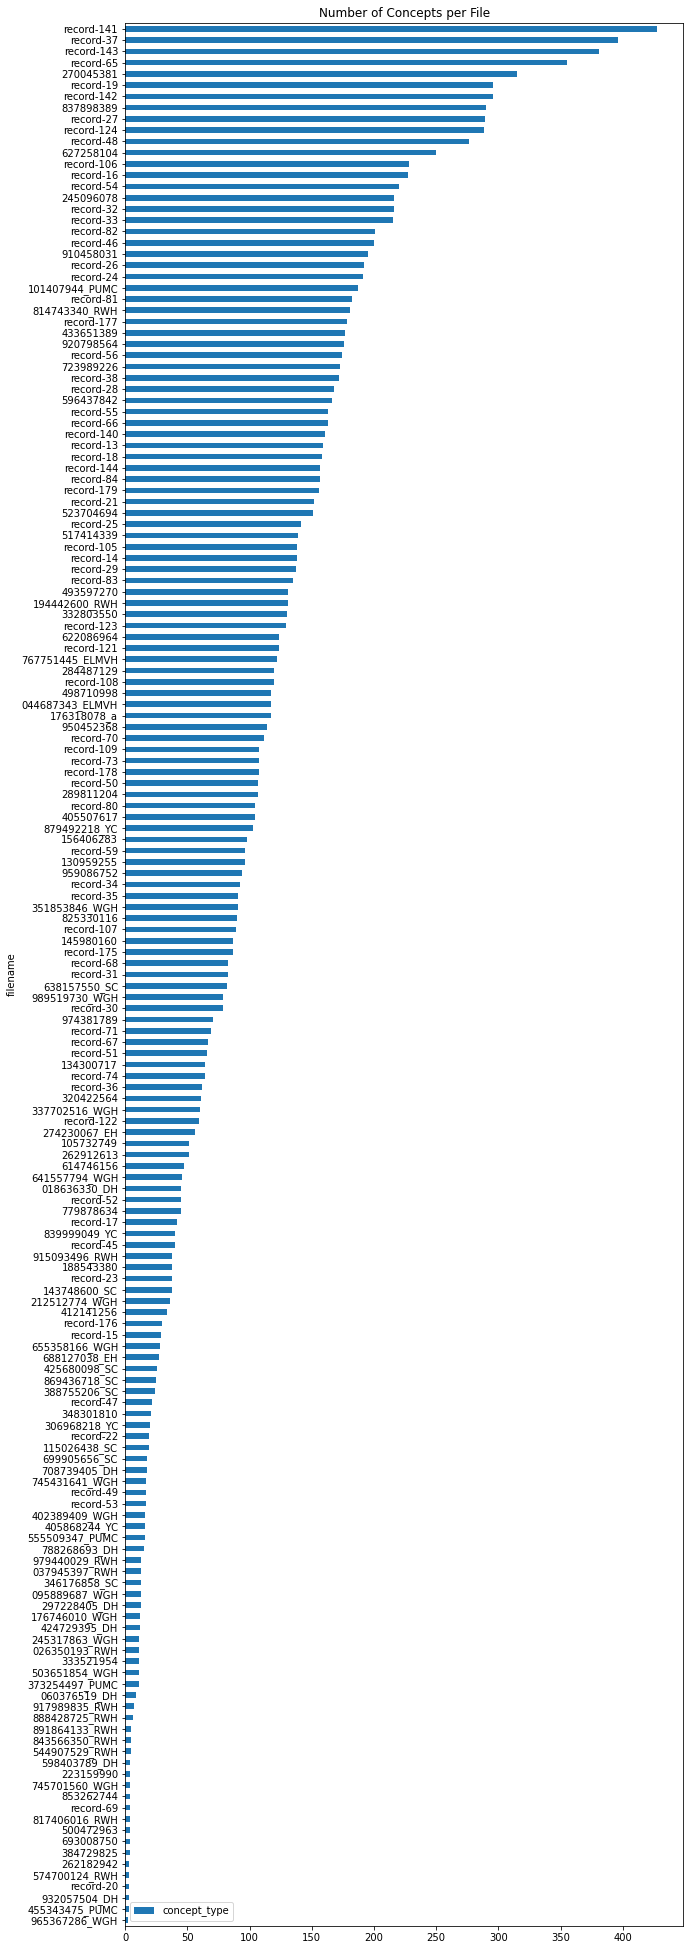

In [14]:
plt.rcParams['figure.figsize'] = [10, 35]
concept_df[["concept_type", "filename"]].groupby("filename").count().sort_values(by="concept_type", ascending=True).plot(kind="barh")
plt.title("Number of Concepts per File")

,filename
concept_type,
problem,7072
test,4607
treatment,4841


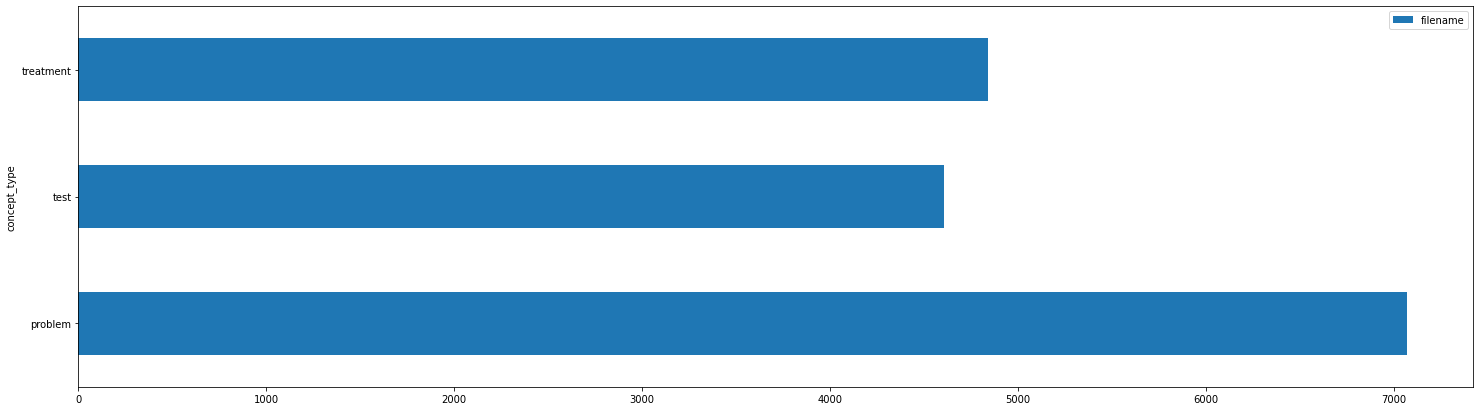

In [13]:
# number of concept types
concept_df[["concept_type", "filename"]].groupby("concept_type").count().plot(kind="barh")
concept_df[["concept_type", "filename"]].groupby("concept_type").count()

### Assertion Analysis

In [32]:
print(df.ast[0])

{'concept_text': ['pain', 'hyperlipidemia', 'her pain', 'cord compression', 'chills', 'hyperreflexia', 'partial decompression of the spinal canal', 'bilateral hand numbness', '10 beats of clonus', 'c5-6 disc herniation', 'cord compression', 'myelopathy', 'these symptoms', 'occasional weakness', 'a c5-6 disc herniation', 'a t2 signal change', 'her hyperreflexia', 'hypertension', 'fevers', 'numbness', 'bowel and bladder disruption', '3-5 beats in the left foot', 'known drug allergy', 'increasing weakness'], 'start_line': [55, 29, 47, 27, 50, 40, 43, 25, 39, 21, 21, 21, 26, 25, 27, 27, 44, 29, 50, 50, 50, 39, 33, 50], 'start_word_number': [10, 4, 0, 16, 9, 2, 8, 11, 16, 0, 4, 7, 5, 15, 11, 19, 9, 2, 7, 14, 17, 25, 3, 11], 'end_line': [55, 29, 47, 27, 50, 40, 43, 25, 39, 21, 21, 21, 26, 25, 27, 27, 44, 29, 50, 50, 50, 39, 33, 50], 'end_word_number': [10, 4, 1, 17, 9, 2, 13, 13, 19, 2, 5, 7, 6, 16, 14, 22, 10, 2, 7, 14, 20, 30, 5, 12], 'concept_type': ['problem', 'problem', 'problem', 'prob

### Relations Analysis

In [33]:
print(df.rel[0])


{'concept_text_1': ['po pain medications', 'a postoperative ct scan', 'percocet', 'c5-6 disc herniation', 'c5-6 disc herniation', 'a c5-6 disc herniation', 'an mri', 'an mri', 'an mri', 'her exam'], 'start_line_1': [47, 43, 55, 21, 21, 27, 27, 27, 27, 44], 'start_word_number_1': [7, 2, 1, 0, 0, 11, 8, 8, 8, 3], 'end_line_1': [47, 43, 55, 21, 21, 27, 27, 27, 27, 44], 'end_word_number_1': [9, 5, 1, 2, 2, 14, 9, 9, 9, 4], 'concept_text_2': ['her pain', 'partial decompression of the spinal canal', 'pain', 'cord compression', 'myelopathy', 'cord compression', 'a c5-6 disc herniation', 'cord compression', 'a t2 signal change', 'her hyperreflexia'], 'start_line_2': [47, 43, 55, 21, 21, 27, 27, 27, 27, 44], 'start_word_number_2': [0, 8, 10, 4, 7, 16, 11, 16, 19, 9], 'end_line_2': [47, 43, 55, 21, 21, 27, 27, 27, 27, 44], 'end_word_number_2': [1, 13, 10, 5, 7, 17, 14, 17, 22, 10], 'relation_type': ['TrIP', 'TeRP', 'TrAP', 'PIP', 'PIP', 'PIP', 'TeRP', 'TeRP', 'TeRP', 'TeCP']}
